In [176]:
# Imports and setup
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import seaborn as sns

In [228]:
nltk.download('stopwords')

# Load and preprocess data
SEED = 42
np.random.seed(SEED)
df = pd.read_csv("msd_dataset_enriched_with_similar_songs.csv")
df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/phoebewang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [229]:
def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords_set])

df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
genre_counts = df['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df = df[df['genre'].isin(valid_genres)]

In [230]:
# downsample overly dominant genres
threshold = 0.3 * len(df)

balanced_dfs = []
for genre, count in df['genre'].value_counts().items():
    genre_df = df[df['genre'] == genre]
    if count > threshold:
        genre_df = resample(genre_df, replace=False, n_samples=int(threshold), random_state=SEED)
    balanced_dfs.append(genre_df)
df = pd.concat(balanced_dfs).sample(frac=1, random_state=SEED)

In [232]:
# tokenize and train Word2Vec
tokenized = df['cleaned_lyrics'].apply(str.split)
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
valid_words = set(w2v_model.wv.index_to_key)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_lyrics'])
sequences = tokenizer.texts_to_sequences(df['cleaned_lyrics'])
embedding_dim = 50
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [233]:
# convert text to sequences and pad them
max_len = max(len(s) for s in sequences)
X = pad_sequences(sequences, maxlen=max_len)

In [234]:
# encode genre labels
le = LabelEncoder()
y = to_categorical(le.fit_transform(df['genre']))
y_labels = np.argmax(y, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_labels),
                                                  y=y_labels)
class_weight_dict = dict(enumerate(class_weights))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [235]:
# LSTM model
input_layer = Input(shape=(X.shape[1],))
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    trainable=False  # Freeze Word2Vec weights initially
)(input_layer)

# LSTM layers
x = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
x = Dropout(0.5)(x)
x = LSTM(32)(x)
x = Dropout(0.5)(x)

output_layer = Dense(y.shape[1], activation='softmax')(x)

# build and compile
model = Model(inputs=input_layer, outputs=output_layer)
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [236]:
# train
early = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64, callbacks=[early])

# evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 645ms/step - accuracy: 0.2646 - loss: 2.5598 - val_accuracy: 0.3378 - val_loss: 2.3526
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.3109 - loss: 2.5195 - val_accuracy: 0.3378 - val_loss: 2.3192
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - accuracy: 0.3303 - loss: 2.4483 - val_accuracy: 0.3378 - val_loss: 2.3150
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step - accuracy: 0.3342 - loss: 2.4006 - val_accuracy: 0.3378 - val_loss: 2.3055
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 572ms/step - accuracy: 0.3393 - loss: 2.4061 - val_accuracy: 0.3378 - val_loss: 2.3064
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 567ms/step - accuracy: 0.3345 - loss: 2.4412 - val_accuracy: 0.3378 - val_loss: 2.2932
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 592ms/step - accuracy: 0.3332 - loss: 2.4152 - val_accuracy: 0.3514 - val_loss: 2.2575
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 593ms/step - accuracy: 0.3656 - loss: 2.3485 - val_accuracy: 0


Test Accuracy: 0.43243243243243246

Classification Report:
              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00         8
     Country       0.00      0.00      0.00        17
  Electronic       0.00      0.00      0.00         6
       Metal       0.00      0.00      0.00        11
  Metal Rock       0.00      0.00      0.00         4
         Pop       0.00      0.00      0.00        16
    Pop Rock       0.00      0.00      0.00         4
        Punk       0.00      0.00      0.00         5
         Rap       0.69      0.95      0.80        21
      Reggae       0.00      0.00      0.00         5
         RnB       0.00      0.00      0.00         6
        Rock       0.38      0.95      0.55        63
  Rock Metal       0.00      0.00      0.00         9
    Rock Pop       0.00      0.00      0.00         5
   Rock Punk       0.00      0.00      0.00         5

    accuracy                           0.43       185
   macro avg       0

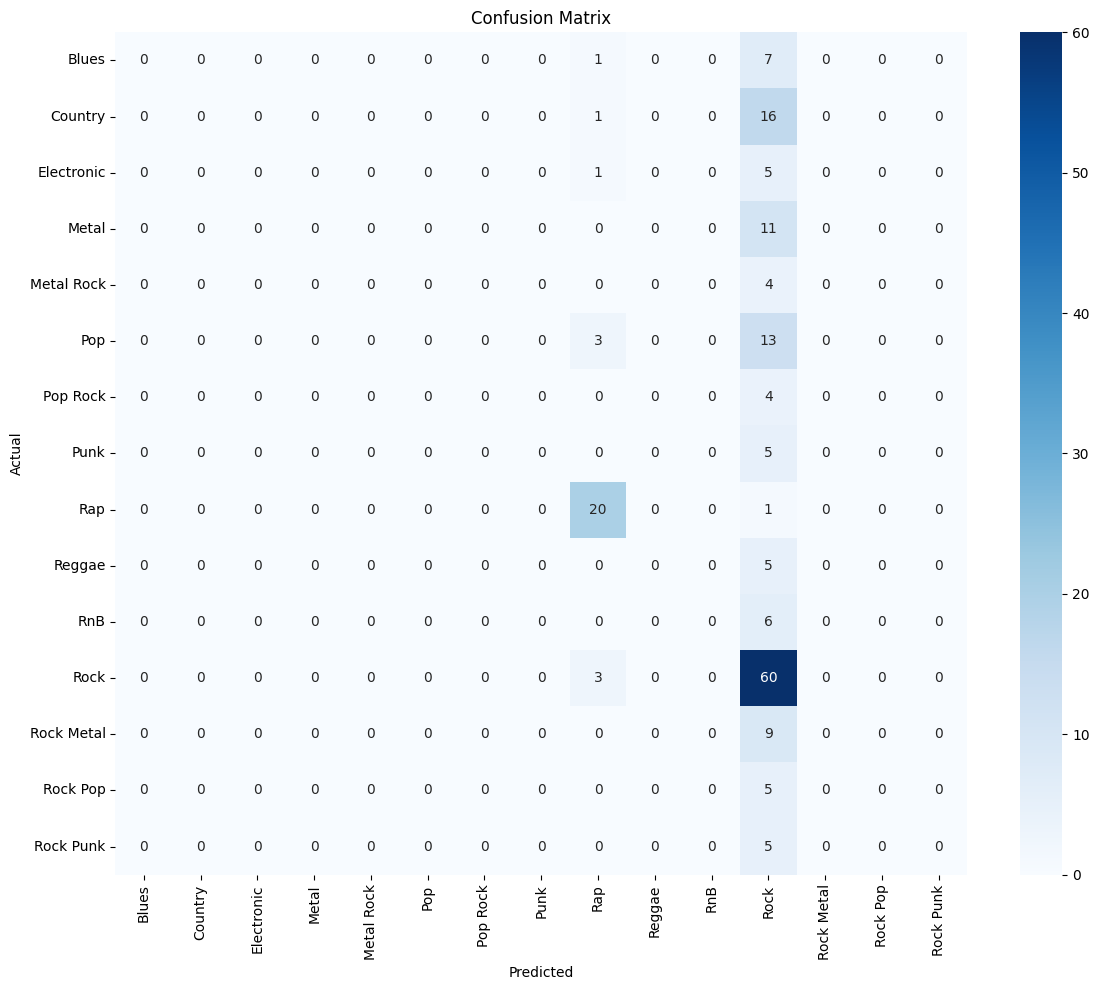

In [237]:
print("\nTest Accuracy:", accuracy_score(y_true, y_pred_classes))
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()